# Twitter Data Preparation

In [1]:
%pip install emoji

In [2]:
import nltk
from nltk.corpus import twitter_samples
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import emoji
import re
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

sns.set_style('darkgrid')

In [3]:
nltk.download('twitter_samples')
nltk.download('punkt')

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Obtendo os dados

In [4]:
positives = twitter_samples.strings('positive_tweets.json')
negatives = twitter_samples.strings('negative_tweets.json')

print("Positivos: ", len(positives), "Negativos: ", len(negatives))

Positivos:  5000 Negativos:  5000


## Estatísticas Iniciais

Neste exercício, temos uma base com 10 mil tweets, entre positivos e negativos. Imaginando que vocês irão utilizar esta base para fazer análise de sentimentos, neste exercícios vocês devem fazer a etapa de pré-processamento de dados.

Como dito em aula, o pré-processamento é um estágio de tomada de decisões, então vocês vão ter que pensar sobre várias decisões, como por exemplo:

 - Tokenização: Tratar todos os símbolos como separadores? E números? Tudo em caixa baixa?
 - Hashtags e Mentions: O que fazer com eles? Tratar como texto? Guardar separado? E as hashtags em camelcase? E os RTs?
 - URLs: Vão ser jogadas fora, substituidas por um token genérico ou transformadas em texto?
 - Remover Stopwords? Lemmatization? Stemming?
 - Outras técnicas de remover ruído dos tokens?
 - Correção de erros de digitação? Com quais limiares?
 - Que outras limpezas devem ser feitas?
 - Como definir o tamanho final do vocabulário a ser considerado e quais palavras estarão nele? (classificadores trabalham com conjuntos finitos de palavras, como veremos em aulas futuras.
 - O que fazer com emojis.


O que entregar:

Este notebook preenchido com a sua exploração desta base de dados, o código para o pre-processamento e, mais importante, as __justificativas__ para as decisões de pré-processamento que vocês estão tomando.

Estatísticas do pré-processamento que também devem ser apresentadas (e serão úteis para as decisões):

 - Total de sentenças. ✅
 - Total de palavras antes e depois do pre-processamento. ✅
 - Total de termos únicos antes e depois. ✅
 - Tamanho do vocabulário final.
 - Média de palavras por tweet e por sentença. ✅
 - Plot de frequência das Top 20 palavras mais comuns. ✅
 - Lista de palavras mais longas. ✅
 - Total de palavras todas em maiúsculo. ✅
 - Total de RTs ✅
 - Total de usuários mencionados e média/tweet. ✅

In [5]:
import string

tweets = []
# remoção de pontuação usando `maketrans` acaba concatenando palavras separadas por vírgula
tweets.extend(positives)
tweets.extend(negatives)

# calculando o total de sentenças
sentences = []
for tweet in tweets:
    sentences.extend(tweet.split('\n'))
print(f'Total de sentenças: {len(sentences)}')

# calculando a fequência de distribuição de tokens
tokens = nltk.word_tokenize(' '.join(tweets))
freqs = nltk.FreqDist(tokens)
freqtot = sum(freqs.values())

# vocabulário inicial é igual ao total de entradas (chaves) no `FreqDist`
print(f'Vocabulário inicial: {len(freqs.keys())}')

# calculando a fequência de distribuição de tokens em maiúsuclo
tokens = nltk.word_tokenize(' '.join(tweets).upper())
freqs = nltk.FreqDist(tokens)

# removendo tokens de pontuação
freqs = dict([(k,freqs[k]) for k in freqs if k.isalnum()])

# calculando o vocabulário total
freqtot = sum(freqs.values())

# vocabulário inicial é igual ao total de entradas (chaves) no `FreqDist`
print(f'Vocabulário inicial maiúsculo: {len(freqs.keys())}')

# a quantidade total de palavras é o somatório das frequências em `FreqDist`
total_tokens = sum([freqs[k] for k in freqs])
print(f'Total de tokens: {total_tokens}')
print(f'Média de tokens por tweet: {freqtot / len(tweets):.2f}')
print(f'Média de tokens por sentença: {freqtot / len(sentences):.2f}')

Total de sentenças: 11414
Vocabulário inicial: 24106
Vocabulário inicial maiúsculo: 17638
Total de tokens: 104006
Média de tokens por tweet: 10.40
Média de tokens por sentença: 9.11


In [6]:
# ordenando decrescente por frequencia
freqs_sorted = sorted(freqs, key=freqs.get, reverse=True)

print('Lista das 20 palavras mais frequentes')
for freq in freqs_sorted[:20]:
    print(' ', freq, '\t', freqs[freq])


Lista das 20 palavras mais frequentes
  I 	 4092
  YOU 	 2386
  TO 	 2187
  THE 	 2003
  A 	 1582
  AND 	 1422
  IT 	 1358
  MY 	 1299
  HTTP 	 1237
  FOR 	 1176
  ME 	 1054
  IS 	 944
  IN 	 936
  SO 	 871
  HAVE 	 803
  OF 	 780
  THAT 	 723
  D 	 686
  ON 	 628
  THIS 	 622


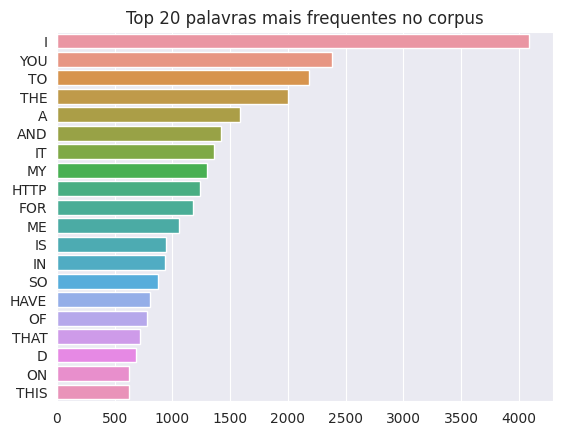

In [7]:
plt.title('Top 20 palavras mais frequentes no corpus')
sns.barplot(y=[k for k in freqs_sorted[:20]], x=[freqs[k] for k in freqs_sorted[:20]])
plt.show()

In [8]:
len_sorted = sorted(freqs.keys(), key=len, reverse=True)

print('Lista das 20 palavras mais longas')
for word in len_sorted[:20]:
    print(' ', len(word), '\t', word)

Lista das 20 palavras mais longas
  46 	 CUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUTE
  43 	 AWUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUU
  42 	 NOTGONNABEACTIVEFOR2WEEKSDONTMISSITTOOMUCH
  35 	 SEXTAATEQUEMFIMSEGUESDVCOMVALENTINO
  33 	 HOTAISNDONWYVAUWJOQHSJSNAIHSUSWTF
  30 	 NGAREPFOLLBACKDARINABILAHJKT48
  29 	 CALLINGANIMALABUSEHOTLINEASAP
  29 	 NIAAAAAAAAAAAAAAAAAAAAAAAAAAA
  28 	 BAJRANGIBHAIJAANHIGHESTWEEK1
  28 	 AKSHAYMOSTLOVEDSUPERSTAREVER
  28 	 LETSHAVECOCKTAILSAFTERNUCLAI
  28 	 HAHAHAHAHAHAHAHAHAHAHAHAHAHA
  26 	 BIRTHDAYMONEYFORJESUSJUICE
  26 	 SPINORBINMUSICXCODYSIMPSON
  25 	 CHOICEINTERNATIONALARTIST
  25 	 JABONGATPUMAURBANSTAMPEDE
  25 	 TEAMSPACEWHALINGISTHEBEST
  24 	 ZAYNISCOMINGBACKONJULY26
  24 	 100REASONSTOVISITMOMBASA
  24 	 BESTEVERDOCTORWHOEPISODE


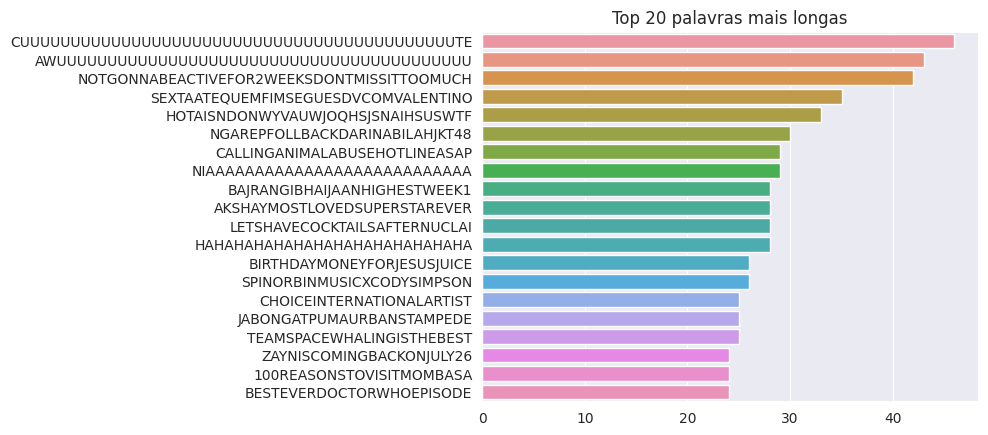

In [9]:
plt.title('Top 20 palavras mais longas')
sns.barplot(y=[k for k in len_sorted[:20]], x=[len(k) for k in len_sorted[:20]])
plt.show()

## Limpeza inicial

Decidi começar removendo URLs pois não vejo sentindo para o contexto de análise de sentimentos.

In [10]:
url_pattern1 = re.compile('https?:\/\/www[a-zA-Z0-9\/\.]+')
url_pattern2 = re.compile('[@a-zA-Z0-9\.\_]+\.com[@a-zA-Z0-9\.\_]?')
twitter_url_pattern = re.compile('https?:\/\/t\.co\/[a-zA-Z0-9]{8,10}')
removed = set()

def remove_urls(tweet: str):
    urls = twitter_url_pattern.findall(tweet)
    for url in urls:
        removed.add(url)
        tweet = tweet.replace(url, ' ')

    urls = url_pattern1.findall(tweet)
    for url in urls:
        removed.add(url)
        tweet = tweet.replace(url, ' ')

    urls = url_pattern2.findall(tweet)
    for url in urls:
        removed.add(url)
        tweet = tweet.replace(url, ' ')

    return tweet

tweets_clean = [remove_urls(tweet) for tweet in tweets]

for r in removed:
    print(r)

https://t.co/6NrxEGjSv3
http://t.co/DphfgsuG1i
http://t.co/7pJJ9q5v7z
http://t.co/pVzUoAaPIO
https://t.co/CQHqWfa7ft
https://t.co/MhK3B3wOpQ
http://t.co/M0TB1ggAU9
http://t.co/TunCUXXIXX
http://t.co/xMohgOWIVJ
http://t.co/InF1DVKHZk
http://t.co/ew7uvaNRyb
http://t.co/S5Az1nSlHX
http://t.co/WEbrI8gAgM
https://t.co/k1MWoiqBiy
http://t.co/6G6C7ewfpf
http://t.co/e8ffJ2a5ro
http://t.co/Ksdgy0lTpF
http://t.co/p6K6SiH58a
http://t.co/Cz4OE19ynN
http://t.co/RB8pMNgMEo
https://t.co/3tfYom0N1i
http://t.co/Lvycav0kNH
http://t.co/hiacH6jXzR
https://t.co/EsCc9QhLob
http://t.co/B7XBAgmERd
http://t.co/tn1yicz40N
https://t.co/FQ6dQHqW8U
https://t.co/Cl0YoptUAg
http://t.co/K8jYN7SdAL
http://t.co/Le7bpWbMlO
https://t.co/DDpk2A4k7z
http://t.co/7IiyoPYtXl
http://t.co/zQh19Rl1t2
http://t.co/qX7XO8x5Zq
https://t.co/qiyrhDK9eB
https://t.co/CgeH8460fh
https://t.co/0II4AHjGV2
http://t.co/8XAFR7meiO
http://t.co/TkF5AeXfRI
http://t.co/0rjSClzGhR
https://t.co/JwNwLUp583
http://t.co/dyvOozCwRN
http://t.co/hhhWQQ1Nh

In [11]:
for k in ['.com','.br','.tv','youtube.com', 'twitch.', 't.co']:
    for t in tweets_clean:
        if k in t:
            print(t)

In [12]:
print(f'Quantidade de URLs distintas removidas: {len(removed)}')

Quantidade de URLs distintas removidas: 1651


In [13]:
assert(len(tweets_clean) == 10 ** 4)

Agora começo a limpeza do texto utilizando os seguintes passos:

1. Converter o format `web` do tweet para `texto` usando `BeautifulSoup`, isso é necessário para trocar por exemplo a codificação `%amp;` por `&`. Isso irá facilitar a remoção de pontuação do texto.
1. Remover as quebras de linha `\n` dos tweets.
1. Substituir ocorrências consecutivas de sinais de pontução, como por exemplo `!!!!!!!` por apenas `!`. Isso reduz os `tokens` e irá facilitar tanto a remoção de pontuação quanto a identificação de `emotes`, pois desse modo os emotes `:))))))))` e `:)))` serão padronizados como `:)`.
1. Por fim o tweet é convertido para `minúsculo`.

In [14]:
from bs4 import BeautifulSoup

def prepare_tweet(tweet: str, remove_duplicate_punct=False):
    tweet = BeautifulSoup(tweet, "lxml").get_text()
    tweet = tweet.expandtabs().replace('\n', ' ')
    if remove_duplicate_punct:
        tweet = re.sub('!+', '!', tweet)
        tweet = re.sub('\.+', '.', tweet)
        tweet = re.sub('\)+', ')', tweet)
        tweet = re.sub('\(+', '(', tweet)
        tweet = re.sub("'+", "'", tweet)
        tweet = re.sub("`+", "`", tweet)
        tweet = re.sub(r"-+", r"-", tweet)
        tweet = re.sub("/+", "/", tweet)
        tweet = re.sub(r" +", ' ', tweet)
    return tweet

tweets_clean = [prepare_tweet(tweet, True) for tweet in tweets_clean]

assert(len(tweets_clean) == 10 ** 4)

tweets_clean

<ipython-input-14-d5093e6c8753>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  tweet = BeautifulSoup(tweet, "lxml").get_text()


['#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)',
 '@Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!',
 '@DespiteOfficial we had a listen last night :) As You Bleed is an amazing track. When are you in Scotland?!',
 '@97sides CONGRATS :)',
 'yeaaaah yippppy! my accnt verified rqst has succeed got a blue tick mark on my fb profile :) in 15 days',
 '@BhaktisBanter @PallaviRuhail This one is irresistible :) #FlipkartFashionFriday ',
 "We don't like to keep our lovely customers waiting for long! We hope you enjoy! Happy Friday! - LWWF :) ",
 '@Impatientraider On second thought, there’s just not enough time for a DD :) But new shorts entering system. Sheep must be buying.',
 'Jgh , but we have to go to Bayan :D bye',
 'As an act of mischievousness, am calling the ETL layer of our in-house warehousing app Katamari. Well… as the name implies :p.',
 '#

## Hashtags


### Estatísticas

In [15]:
from collections import Counter

hashtag_pattern = re.compile('#[a-zA-Z\-]+')

counter = Counter()

for t in tweets_clean:
    rs = hashtag_pattern.findall(t)
    if rs:
        counter.update(rs)

print(f'Quantidade de hashtags únicas: {len(counter.keys())}')
print(f'Total de hashtags: {sum(counter.values())}')
print(f'Média de hashtags por Tweet: {sum(counter.values()) / len(tweets_clean)}')

Quantidade de hashtags únicas: 1179
Total de hashtags: 2160
Média de hashtags por Tweet: 0.216


In [16]:
# ordenando decrescente por frequencia
tags_sorted = sorted(counter, key=counter.get, reverse=True)

print('Lista das 20 hashtags mais frequentes')
for tag in tags_sorted[:20]:
    print(counter[tag], '\t', tag)

Lista das 20 hashtags mais frequentes
55 	 #snapchat
47 	 #kik
31 	 #FF
25 	 #FollowFriday
23 	 #ZaynIsComingBackOnJuly
19 	 #WSaleLove
19 	 #hornykik
18 	 #kikgirl
17 	 #FlipkartFashionFriday
16 	 #kikmeboys
15 	 #TeenChoice
15 	 #ff
15 	 #indiemusic
15 	 #UberIceCream
14 	 #SuperJunior
14 	 #kikhorny
13 	 #ChoiceInternationalArtist
13 	 #retweet
12 	 #kikmenow
11 	 #BrainDots


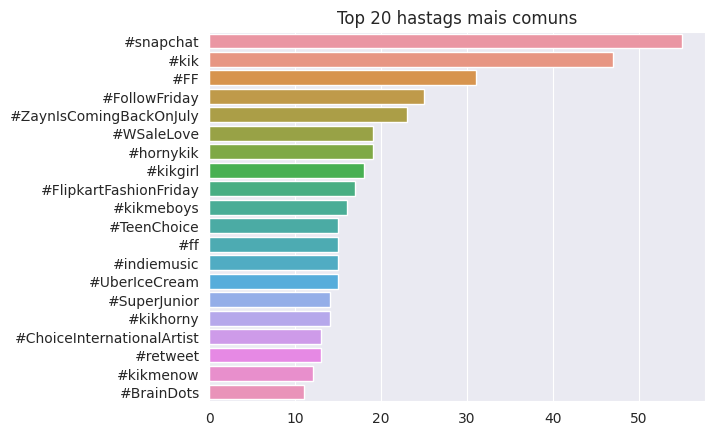

In [17]:
plt.title('Top 20 hastags mais comuns')
sns.barplot(y=[tag for tag in tags_sorted[:20]], x=[counter[tag] for tag in tags_sorted[:20]])
plt.show()

Acredito que as tags contenham informações relevantes para um modelo de análise sentimental, sendo assim irei tratar as Hashtags usando a seguinte abordagem:

- Remover o `#`
- As hashtags em `PascalCase` serão splitadas em palavras separadas, como por exemplo `#BraindDots` resultará em `Brain Dots`

In [18]:
def case_split(identifier):
    matches = re.finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', identifier)
    return ' '.join([m.group(0).strip() for m in matches])

def prepare_hashtag(tweet: str):
    tags = hashtag_pattern.findall(tweet)
    for tag in tags:
        tweet = tweet.replace(tag, case_split(tag.replace('#', '')))
    return tweet

tweets_clean = [prepare_hashtag(tweet) for tweet in tweets_clean]
tweets_clean

['Follow Friday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)',
 '@Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!',
 '@DespiteOfficial we had a listen last night :) As You Bleed is an amazing track. When are you in Scotland?!',
 '@97sides CONGRATS :)',
 'yeaaaah yippppy! my accnt verified rqst has succeed got a blue tick mark on my fb profile :) in 15 days',
 '@BhaktisBanter @PallaviRuhail This one is irresistible :) Flipkart Fashion Friday ',
 "We don't like to keep our lovely customers waiting for long! We hope you enjoy! Happy Friday! - LWWF :) ",
 '@Impatientraider On second thought, there’s just not enough time for a DD :) But new shorts entering system. Sheep must be buying.',
 'Jgh , but we have to go to Bayan :D bye',
 'As an act of mischievousness, am calling the ETL layer of our in-house warehousing app Katamari. Well… as the name implies :p.',
 '

## Usuários mencionados

- Segundo a página [Helo with your username](https://help.twitter.com/en/managing-your-account/twitter-username-rules#:~:text=Your%20username%20cannot%20be%20longer,of%20underscores%2C%20as%20noted%20above.) os nomes de usuários no Twitter devem ter até 15 caracteres do conjunto `[A-Z0-9_]`.

- Fiz uma busca na internet e não encontrei artigos que dessem orientações quanto ao pré-processamento de `usernames`. Sendo assim minha ideia é de que essa informação não seja relevante para tarefas de `análise de sentimentos`.

In [19]:
from collections import Counter

username_pattern = re.compile('@[A-Z0-9_]+', re.IGNORECASE)

mentions = []

for tweet in tweets_clean:
    usernames = username_pattern.findall(tweet)
    if usernames:
        mentions.extend(usernames)

contador = Counter(mentions)

print(f'Total menções a usuários: {sum(contador.values())}')
print(f'Total usuários mencionados: {len(contador.keys())}')
print(f'Média de menções por tweet: {sum(contador.values()) / len(tweets_clean)}')

Total menções a usuários: 8262
Total usuários mencionados: 7139
Média de menções por tweet: 0.8262


### Top 20 usuários mais mencionados

- Existem muitas menções a artistas.
- Não existe muito padrão nos nomes de usuários.

In [20]:
df_mentions = pd.DataFrame(contador.items(), columns=['username', 'n_mentions'])
df_mentions.sort_values(by='n_mentions', ascending=False).head(20)

,username,n_mentions
168,@justinbieber,102
12,@jnlazts,62
32,@BarsAndMelody,44
33,@969Horan696,44
22,@tolajobjobs,19
47,@YouTube,18
128,@imPastel,17
6,@BhaktisBanter,17
4356,@JayMcGuiness,17
163,@WforWoman,15


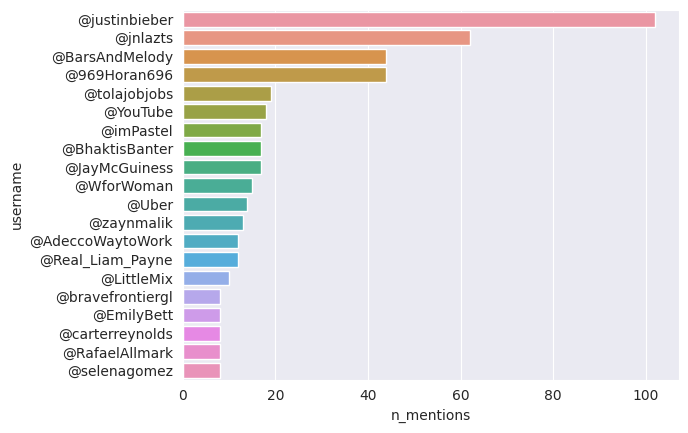

In [21]:
sns.barplot(data=df_mentions.sort_values(by='n_mentions', ascending=False).head(20), y='username', x='n_mentions')
# plt.xticks(rotation=90)
plt.show()

In [22]:
def prepare_mentions(tweet: str):
    results = username_pattern.findall(tweet)
    for name in results:
        tweet = tweet.replace(name, ' ')

    return tweet

tweets_clean = [prepare_mentions(tweet) for tweet in tweets_clean]
tweets_clean

['Follow Friday       for being top engaged members in my community this week :)',
 '  Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!',
 '  we had a listen last night :) As You Bleed is an amazing track. When are you in Scotland?!',
 '  CONGRATS :)',
 'yeaaaah yippppy! my accnt verified rqst has succeed got a blue tick mark on my fb profile :) in 15 days',
 '    This one is irresistible :) Flipkart Fashion Friday ',
 "We don't like to keep our lovely customers waiting for long! We hope you enjoy! Happy Friday! - LWWF :) ",
 '  On second thought, there’s just not enough time for a DD :) But new shorts entering system. Sheep must be buying.',
 'Jgh , but we have to go to Bayan :D bye',
 'As an act of mischievousness, am calling the ETL layer of our in-house warehousing app Katamari. Well… as the name implies :p.',
 'Follow Friday     for being top influencers in my community this week :)',
 "Who Wouldn't Love These Bi

## Emojis e Emotes
- O tutorial de [Bael Chen](https://towardsdatascience.com/emojis-aid-social-media-sentiment-analysis-stop-cleaning-them-out-bb32a1e5fc8e) demonstra brevemente que alguns modelos (independente do método de tokenização utilizado) podem trazer resultados melhores quando so `emojis` são mantidos no testo.

- O artigo [Sentiment of Emojis, Petra Novak et. al.](https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0144296&type=printable) faz uma análise da relevência dos Emojis para análise sentimental.

- Sendo assim, decidi manter os `emojis` no texto, porém realizarei uma substituição por tags mais explicativas, por exemplo o emoji 😀 será substituído por `smile`.

- Os `emotes` (`^.^` por exemplo) são muito variáveis e não apresentam uma formatação tão lógica, sendo assim serão removidos junto com a `pontuação`.


### Estatísticas

In [23]:
emoji_freq = [emoji.emoji_count(tweet) for tweet in tweets_clean]
emoji_freq = np.array(emoji_freq)

print(f"{'ANÁLISE ESTATÍSTICA DE EMOJIS':-^60}")

print(f'{"Freq Acum":^10}|{"MAX Freq":^10}|{"MIN Freq":^10}|{"Mean":^18}|{"Median":^10}')
print(f'{emoji_freq.sum():^10}|{emoji_freq.max():^10}|{emoji_freq.min():^10}|{f"{emoji_freq.mean()} (+-{emoji_freq.std():.2f})":^18}|{np.median(emoji_freq):^10}')
print('-'*60)


---------------ANÁLISE ESTATÍSTICA DE EMOJIS----------------
Freq Acum | MAX Freq | MIN Freq |       Mean       |  Median  
   604    |    16    |    0     | 0.0604 (+-0.51)  |   0.0    
------------------------------------------------------------


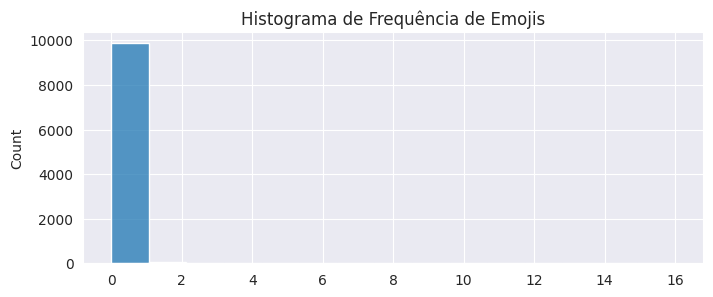

In [24]:
plt.figure(figsize=(8, 3))
plt.title('Histograma de Frequência de Emojis')
sns.histplot(emoji_freq)
plt.show()

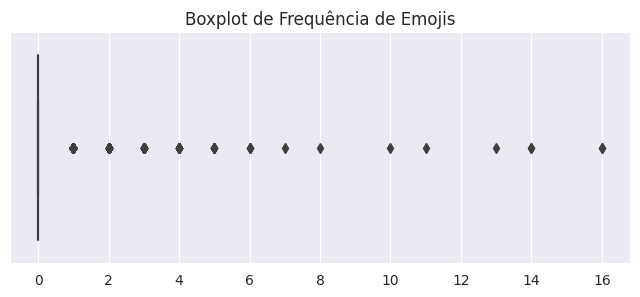

In [25]:
plt.figure(figsize=(8, 3))
plt.title('Boxplot de Frequência de Emojis')
sns.boxplot(x=emoji_freq)
plt.show()

In [26]:
print(f'q1={np.quantile(emoji_freq, .25)}\nq2={np.quantile(emoji_freq, .5)}\nq3={np.quantile(emoji_freq, .75)}')

q1=0.0
q2=0.0
q3=0.0


In [27]:
def process_emojis(text:str, remove_emojis=False):
    if remove_emojis:
        emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)
    return emoji.demojize(text)

def prepare_emoji(tweet: str, remove_emojis=False):
    tweet = process_emojis(tweet, remove_emojis) # traduz emojis
    tweet = tweet.replace(':', ' ') # separa emojis consecutivos
    return tweet.lower()

In [28]:
tweets_clean = [prepare_emoji(tweet) for tweet in tweets_clean]
tweets_clean

['follow friday       for being top engaged members in my community this week  )',
 '  hey james! how odd  / please call our contact centre on 02392441234 and we will be able to assist you  ) many thanks!',
 '  we had a listen last night  ) as you bleed is an amazing track. when are you in scotland?!',
 '  congrats  )',
 'yeaaaah yippppy! my accnt verified rqst has succeed got a blue tick mark on my fb profile  ) in 15 days',
 '    this one is irresistible  ) flipkart fashion friday ',
 "we don't like to keep our lovely customers waiting for long! we hope you enjoy! happy friday! - lwwf  ) ",
 '  on second thought, there’s just not enough time for a dd  ) but new shorts entering system. sheep must be buying.',
 'jgh , but we have to go to bayan  d bye',
 'as an act of mischievousness, am calling the etl layer of our in-house warehousing app katamari. well… as the name implies  p.',
 'follow friday     for being top influencers in my community this week  )',
 "who wouldn't love these bi

## Pontuação

Os caracteres de pontuação serão removidos.

In [29]:
def prepare_punct(tweet: str):
    new_tweet = ''
    for c in tweet:
        if c.isalpha():
            new_tweet += c
        else:
            new_tweet += ' '
    return re.sub(' +', ' ', new_tweet).strip()

tweets_clean = [prepare_punct(tweet) for tweet in tweets_clean]
tweets_clean

['follow friday for being top engaged members in my community this week',
 'hey james how odd please call our contact centre on and we will be able to assist you many thanks',
 'we had a listen last night as you bleed is an amazing track when are you in scotland',
 'congrats',
 'yeaaaah yippppy my accnt verified rqst has succeed got a blue tick mark on my fb profile in days',
 'this one is irresistible flipkart fashion friday',
 'we don t like to keep our lovely customers waiting for long we hope you enjoy happy friday lwwf',
 'on second thought there s just not enough time for a dd but new shorts entering system sheep must be buying',
 'jgh but we have to go to bayan d bye',
 'as an act of mischievousness am calling the etl layer of our in house warehousing app katamari well as the name implies p',
 'follow friday for being top influencers in my community this week',
 'who wouldn t love these big juicy selfies',
 'follow follow u back',
 'perfect so you already know what s waiting for

## Correção gramatical

Como os tweets são proveninentes de uma ambiente web, é esperado que os usuário não respeitem as normas gramaticais da linguagem, o que pode atrapalhar a análise sentimental pois na lingua inglesa até a simples alteração na ordem de uma palavra pode alterar seu sentido.

Por isso, tentei aplicar o modelo de correção gramatical `happytransformer` nos tweets, contudo não houveram modificações significativas nos textos.

Além disso, também testei as abordagens clássicas utilizando `distância de edição mínima` e `distância de jaccard`. Ocorreu que muitas vezes estas resultam em palavras fora do contexto.

Sendo assim, adotei apenas algumas correções `heurísticas`

Substituir algumas contrações, comuns na língua inglesa, pela forma estendida

In [30]:
def extend_contractions(tweet: str):
    tweet = re.sub(r"(are|do|did|does|would|have|can|could|should|had|was)n?('|\s)t", r"\1 not", tweet)
    tweet = re.sub(r"(she|he|it|they|what|that|where|there|who|here|when|how)('|\s)s", r"\1 is", tweet)
    tweet = re.sub(r"(i|they|what|that|where|there|who|here|when|how)('|\s)s", r"\1 is", tweet)
    return tweet

tweets_clean = [extend_contractions(tweet) for tweet in tweets_clean]
tweets_clean

['follow friday for being top engaged members in my community this week',
 'hey james how odd please call our contact centre on and we will be able to assist you many thanks',
 'we had a listen last night as you bleed is an amazing track when are you in scotland',
 'congrats',
 'yeaaaah yippppy my accnt verified rqst has succeed got a blue tick mark on my fb profile in days',
 'this one is irresistible flipkart fashion friday',
 'we do not like to keep our lovely customers waiting for long we hope you enjoy happy friday lwwf',
 'on second thought there is just not enough time for a dd but new shorts entering system sheep must be buying',
 'jgh but we have noto go to bayan d bye',
 'as an act of mischievousness am calling the etl layer of our in house warehousing app katamari well as the name implies p',
 'follow friday for being top influencers in my community this week',
 'who would not love these big juicy selfies',
 'follow follow u back',
 'perfect so you already know what is waiti

Também construí um `dict`com gírias encontradas na base e irei convertê-las para seu significado.

In [31]:
slangs = {
    'u': 'you',
    'y': 'you',
    "bffs": 'best friends forever',
    'bff': 'best friends forever',
    'bf': 'best friend',
    "gfs": 'girlfriends',
    "oomf": 'one of my friends',
    'smh': 'shake my head',
    'lolz': 'laughing out loud',
    'lols': 'laughing out loud',
    'lol': 'laughing out loud',
    'ofc': 'of course',
    'utd': 'up to date',
    'tmr': 'tomorrow',
    'tmrw': 'tomorrow',
    'omfg': 'oh my fucking god',
    'omf': 'oh my god',
    'xmas': 'christmas',
    'wat': 'what',
    'wtf': 'what that fuck',
    'dm': 'direct message',
    'dms': 'direct messages',
    'wth': 'what that hell',
    'imma': 'i am going to',
    'ill': 'i will',
    'txt': 'text',
    'dat': 'that',
    'rofl': 'rolled on the floor laughing',
    'istg': 'i swear to god',
    'btwn': 'between',
    'tfw': 'that feel when',
    'msg': 'message',
    'msgs': 'messages',
    'arent': 'are not',
    'tbf': 'to be fair',
    'rtss': 'retweets',
    'ikr': 'i know right',
    'yrs': 'years',
    'nw': 'no worries',
    'prob': 'probally',
    'lmao': 'laughing my ass off',
    'lmaoo': 'laughing my ass off',
    'gotta': 'got to',
    'hopeyou': 'hope you',
    'nxt': 'next',
    'ftw': 'for the win',
    'brb': 'be right back',
    'img': 'image',
    'feb': 'february',
    'fnaf': "five night's at freddy's",
    'gl': 'good luck',
    'gn': 'good night',
    'ty': 'thank you',
    'cya': 'see you all',
    'ttyl': 'talk to you later',
    'plz': 'please',
    'pls': 'please',
    'ffs': 'for fucks sake',
    'tkts': 'tickets',
    'fyi': 'for your information',
    'otw': 'on the way',
    'fck': 'fuck',
    'sry': 'sorry',
    'lyf': 'love you forever',
    'luv': 'love',
    'nvm': 'nevermind',
    'r': 'are',
    'cuz': 'cause',
    'fb': 'facebook',
    'ur': 'you are',
    'rply': 'reply',
    'knw': 'know',
    'rly': 'really',
    'fany': 'funny',
    'atty': 'attorney',
    'alrd': 'already',
    'pic': 'picture',
    'pics': 'pictures',
    'otp': 'one true pairing',
    'bday': 'birthday',
    'lil': 'little',
    'cz': 'cause',
    'ppl': 'people',
    'ytb': 'youtube',
    'tym': 'thank you soo much',
    'plss': 'please',
    'lils': 'littles',
    'tdy': 'today',
    'fav': 'favorite'
}

In [32]:
def replace_slang(tweet: str):
    return ' '.join([slangs.get(word, word) for word in tweet.split(' ')])

tweets_clean = [replace_slang(tweet) for tweet in tweets_clean]
tweets_clean

['follow friday for being top engaged members in my community this week',
 'hey james how odd please call our contact centre on and we will be able to assist you many thanks',
 'we had a listen last night as you bleed is an amazing track when are you in scotland',
 'congrats',
 'yeaaaah yippppy my accnt verified rqst has succeed got a blue tick mark on my facebook profile in days',
 'this one is irresistible flipkart fashion friday',
 'we do not like to keep our lovely customers waiting for long we hope you enjoy happy friday lwwf',
 'on second thought there is just not enough time for a dd but new shorts entering system sheep must be buying',
 'jgh but we have noto go to bayan d bye',
 'as an act of mischievousness am calling the etl layer of our in house warehousing app katamari well as the name implies p',
 'follow friday for being top influencers in my community this week',
 'who would not love these big juicy selfies',
 'follow follow you back',
 'perfect so you already know what 

In [33]:
# from nltk.metrics.distance import edit_distance, jaccard_distance

# nltk.download('words')
# from nltk.corpus import words
# correct_words = words.words()

# tweets2 = [t.lower() for t in tweets_clean]

# c = set()
# for t in tweets2:
#     for w in t.split(' '):
#         if not w in correct_words):
#             c.add(w)

# print(len(c))
# print(c)

In [34]:
# from nltk.metrics.distance import jaccard_distance
# from nltk.util import ngrams

# incorrect_words=['ystrday', 'crazyyyy', 'selamat']

# for word in incorrect_words:
#     temp = [(jaccard_distance(set(ngrams(word, 2)),
#                               set(ngrams(w, 2))),w)
#             for w in correct_words if w[0]==word[0]]
#     print(sorted(temp, key = lambda val:val[0])[0][1])

In [35]:
# # !pip install happytransformer
# from happytransformer import HappyTextToText, TTSettings

# happy_tt = HappyTextToText("T5", "vennify/t5-base-grammar-correction")
# args = TTSettings(num_beams=5, min_length=1)

# def prepare_grammar(tweet: str):
#     # Add the prefix "grammar: " before each input
#     result = happy_tt.generate_text(f"grammar: {tweet}.", args=args)
#     return result.text

# for i in [810, 811, 972, 292]:
#     print(tweets_punct[i], end=' => ')
#     print(prepare_grammar(tweets_punct[i]))
#     print()

## Stopwords, Stemming e Lemmatization

Para a análise de sentimentos talvez seja importante manter `stopwords`, como por exemplo:

Na sentença `I didn’t like the product (Negative)` a remoção das `stopwords` resultaria em 	`like product (Positive)`.

In [36]:
# import spacy

# #loading the english language small model of spacy
# en = spacy.load('en_core_web_sm')
# sw_spacy = en.Defaults.stop_words

# print(sw_spacy)

In [37]:
# def remove_stopwords(tweet: str):
#     return ' '.join([word for word in tweet.split() if word.lower() not in sw_spacy])

# tweets_clean = [remove_stopwords(tweet) for tweet in tweets_clean]
# tweets_clean

Agora quanto ao processo de `stemming` geralmente pode resultar em palavras inexistentes na gramática e por isso não irei utilizar.

Por fim, irei aplicar `lemmatization` reduzindo as palavras a um radical existe de modo que o vocabulário final será reduzido também.

In [38]:
import spacy

nlp = spacy.load("en_core_web_sm")

In [39]:
def tweet_lemmatization(tweet: str):
    doc = nlp(tweet)
    return " ".join([token.lemma_ for token in doc])

tweets_clean = [tweet_lemmatization(tweet) for tweet in tweets_clean]
tweets_clean

['follow friday for be top engage member in my community this week',
 'hey jame how odd please call our contact centre on and we will be able to assist you many thank',
 'we have a listen last night as you bleed be an amazing track when be you in scotland',
 'congrat',
 'yeaaaah yippppy my accnt verify rqst have succeed get a blue tick mark on my facebook profile in day',
 'this one be irresistible flipkart fashion friday',
 'we do not like to keep our lovely customer wait for long we hope you enjoy happy friday lwwf',
 'on second thought there be just not enough time for a dd but new short enter system sheep must be buy',
 'jgh but we have noto go to bayan d bye',
 'as an act of mischievousness be call the etl layer of our in house warehousing app katamari well as the name imply p',
 'follow friday for be top influencer in my community this week',
 'who would not love these big juicy selfie',
 'follow follow you back',
 'perfect so you already know what be wait for you',
 'great new o

In [40]:
assert(len(tweets_clean) == 10 ** 4)

## Vocabulário final

In [41]:
import string

# calculando a fequência de distribuição de tokens
tokens = nltk.word_tokenize(' '.join(tweets_clean))
freqs = nltk.FreqDist(tokens)

print(f'Vocabulário final: {len(freqs.keys())}')
total_tokens = sum([freqs[k] for k in freqs])
print(f'Total de tokens: {total_tokens}')
print(f'Média de tokens por tweet: {freqtot / len(tweets_clean):.2f}')

Vocabulário final: 10214
Total de tokens: 101908
Média de tokens por tweet: 10.40


Comparando como o valores iniciais:

- Vocabulário: ${V}_{i} = 17.638$ e ${V}_{f} = 10.186$ uma redução de $42.25 \%$.
- Total Tokens: ${TT}_{i} = 104.006$ e ${TT}_{f} = 101.688$ uma redução de $2.23 \%$

In [42]:
# ordenando decrescente por frequencia
freqs_sorted = sorted(freqs, key=freqs.get, reverse=True)

print('Lista das 20 palavras mais frequentes')
for freq in freqs_sorted[:20]:
    print(f"{freq}\t\t{freqs[freq]}")


Lista das 20 palavras mais frequentes
I		5390
be		3556
you		2976
to		2187
the		1952
a		1630
and		1425
not		1423
it		1368
my		1337
for		1197
do		1102
have		1097
in		946
so		856
of		829
d		784
thank		750
that		749
m		745


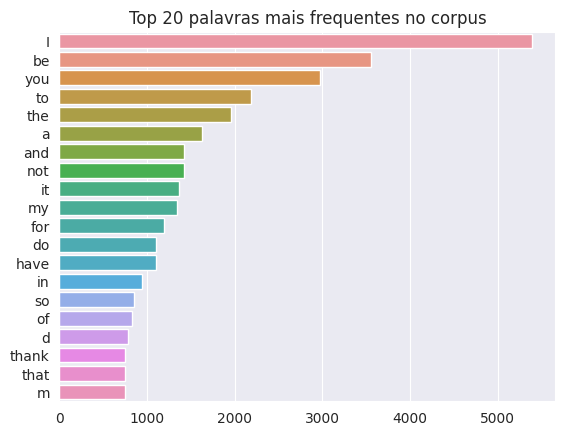

In [43]:
plt.title('Top 20 palavras mais frequentes no corpus')
sns.barplot(y=[k for k in freqs_sorted[:20]], x=[freqs[k] for k in freqs_sorted[:20]])
plt.show()

In [44]:
len_sorted = sorted(freqs.keys(), key=len, reverse=True)

print('Lista das 20 palavras mais longas')
for word in len_sorted[:20]:
    print(' ', len(word), '\t', word)

Lista das 20 palavras mais longas
  46 	 cuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuute
  43 	 awuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu
  35 	 sextaatequemfimseguesdvcomvalentino
  33 	 hotaisndonwyvauwjoqhsjsnaihsuswtf
  29 	 callinganimalabusehotlineasap
  29 	 niaaaaaaaaaaaaaaaaaaaaaaaaaaa
  28 	 letshavecocktailsafternuclai
  28 	 hahahahahahahahahahahahahaha
  26 	 birthdaymoneyforjesusjuice
  24 	 besteverdoctorwhoepisode
  23 	 amassiveoverdoseofships
  23 	 sexygirlbypreciouslemmy
  22 	 sadomasochistsparadise
  22 	 sabadodeganarseguidore
  22 	 walangmakakapigilsakin
  22 	 weeksdontmissittoomuch
  21 	 reasonstovisitmombasa
  21 	 hotfmnoaidilforariana
  21 	 mybrainneedstoshutoff
  20 	 ineedfeminismbecause


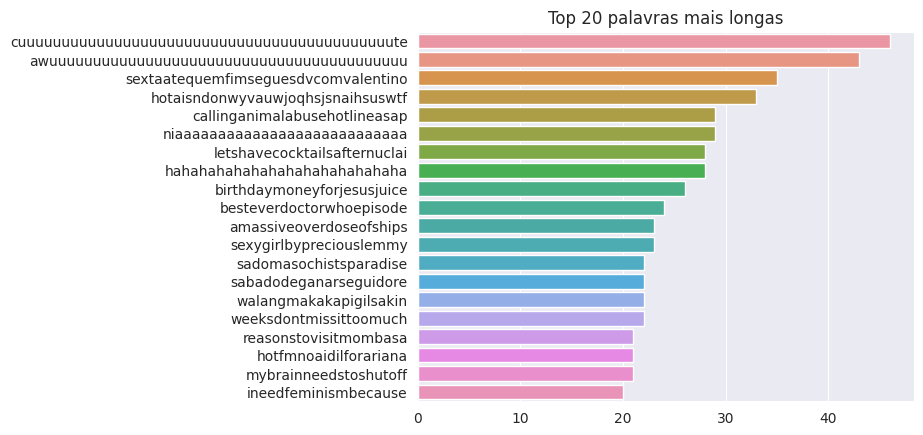

In [45]:
plt.title('Top 20 palavras mais longas')
sns.barplot(y=[k for k in len_sorted[:20]], x=[len(k) for k in len_sorted[:20]])
plt.show()

## Base Model for Sentiment Analysis (Pipeline)

In [46]:
!pip install -q transformers
!pip install xformers

In [47]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-4c0eb52c-e934-ef1b-7902-1292a2db655b)


In [48]:
from transformers import pipeline

# set gpu
device = 0 if torch.cuda.is_available() else -1
sentiment_pipeline = pipeline("text-classification", device=device)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [49]:
from sklearn.metrics import confusion_matrix, classification_report

def sentiment_score(model_name: str, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    print(classification_report(y_true, y_pred, target_names=['POSITIVE', 'NEGATIVE']))

    plt.title(f'BERT Confusion Matrix = {model_name.upper()}')
    ax=sns.heatmap(cm, annot=True, fmt='d')
    ax.set(xlabel='Predicted Label', ylabel='True Label')
    plt.plot()

    return cm

In [50]:
def calculate_scores(model: str, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    acc = (cm[0][0] + cm[1][1]) / cm.sum()
    err = (cm[0][1] + cm[1][0]) / cm.sum()
    n_prec = cm[0][0] / (cm[0][0] + cm[1][0])
    p_prec = cm[1][1] / (cm[1][1] + cm[0][1])
    n_rec = cm[0][0] / (cm[0][0] + cm[0][1])
    p_rec = cm[1][1] / (cm[1][0] + cm[1][1])
    return {
        'accuracy': [acc],
        'error_rate': [err],
        'negative_precision': [n_prec],
        'positive_precision': [p_prec],
        'negative_recall': [n_rec],
        'positive_recall': [p_rec]
    }

In [51]:
def evaluate_model(model_name: str, tweets, y_true):
    results = sentiment_pipeline(tweets)
    y_pred = [r['label'] for r in results]
    cm = sentiment_score(model_name, y_true, y_pred)

    model_scores = calculate_scores(model_name, y_true, y_pred)
    model_scores['model'] = model_name
    return model_scores

              precision    recall  f1-score   support

    POSITIVE       0.69      0.67      0.68      5000
    NEGATIVE       0.68      0.69      0.69      5000

    accuracy                           0.68     10000
   macro avg       0.68      0.68      0.68     10000
weighted avg       0.68      0.68      0.68     10000



{'accuracy': [0.6813],
 'error_rate': [0.3187],
 'negative_precision': [0.6861778599301704],
 'positive_precision': [0.6766712141882674],
 'negative_recall': [0.6682],
 'positive_recall': [0.6944],
 'model': 'tweets_base_model'}

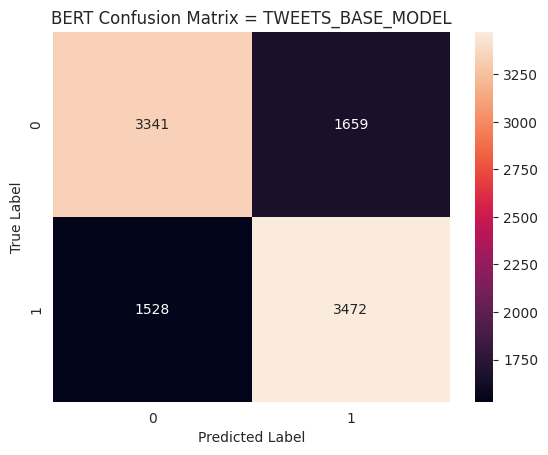

In [52]:
y_true = ['POSITIVE' for _ in range(5000)] + ['NEGATIVE' for _ in range(5000)]
scores = evaluate_model('tweets_base_model', tweets_clean, y_true)
scores

In [53]:
df_model_scores = pd.DataFrame(scores)
df_model_scores

,accuracy,error_rate,negative_precision,positive_precision,negative_recall,positive_recall,model
0,0.6813,0.3187,0.686178,0.676671,0.6682,0.6944,tweets_base_model


O modelo base usando o `pipeline` de classificação de texto obteve uma acurácia de `0.68`, com precisão de `0.69` para classe `NEGATIVE`. e `0.67` para a classe `POSITIVE`.